# Representational Similarity Analyses

In [1]:
import os, requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr, zscore
from copy import deepcopy

In [2]:
#@title Data file access
# give google colab access to your drive
wd="/Users/miriam/GoogleDrive/GraduateWork/trainings/Neuromatch Academy/data/"
if wd=="drive/My Drive/data/":
    from google.colab import drive
    drive.mount('/content/drive')


all_fnames = ['gratings_noisy_GT1_2019_04_08_1.npy', \
          'gratings_static_GT1_2019_04_17_1.npy',\
          'minnie_GT1_2019_04_29_2.npy',\
          'gratings_drifting_GT1_2019_04_12_1.npy',\
          'gratings_local_GT1_2019_04_27_2.npy']
fname_keys = ['noisy', 'static', 'minnie', 'drifting', 'local']


In [3]:
#@title Data loading
# load this mouse's data
dats={}
# which files do you want to load?
idx = [1,2]#range(len(fname_keys))
# load each file and save it in a new array
for ind in idx:
  dats[fname_keys[ind]] = np.load(os.path.join(wd, all_fnames[ind]), allow_pickle=True).item()


In [4]:
dats['static']['sresp'].shape

(23589, 4598)

In [5]:
from scipy.spatial import distance_matrix
def make_rdm(dat, dist="correlation", return_lowertri=False, plot=True, title="Correlation Matrix", save_plot=False):
  n_cond = len(dat['istim'])
  stim_order = np.argsort(dat['istim'])
  istim_ordered = dat['istim'][stim_order]
  sresp_ordered = dat['sresp'][:,stim_order]
  if dist=="correlation":
    rdm = 1 - np.corrcoef(sresp_ordered.T)
  elif dist=="euclidean":
    rdm = distance_matrix(sresp_ordered.T, sresp_ordered.T)
  if return_lowertri:
    rdm = rdm[np.tril_indices(len(rdm), k=-1)] # extract the lower triangle
  if plot:
    plt.figure(figsize=(10,10))
    plt.imshow(rdm, origin = 'lower')
    plt.colorbar(format = '%.2f')
    plt.xticks(ticks = (np.array([0,0.5,1,1.5,2]))*len(dat['istim'])/2, labels = ['0','$\\frac{\pi}{2}$','$\pi$', '$\\frac{3\pi}{2}$', '$2\pi$'],fontsize = 14)
    plt.yticks(ticks = (np.array([0,0.5,1,1.5,2]))*len(dat['istim'])/2, labels = ['0','$\\frac{\pi}{2}$','$\pi$', '$\\frac{3\pi}{2}$', '$2\pi$'],fontsize = 14)
    plt.title(title, fontsize = 14)
    plt.clim([0, 2])
    if save_plot:
        plt.savefig(os.path.join(wd,'RDMs','RDM_'+title+'.png'))
  return rdm, istim_ordered


def make_rdm_func_conn(dat, size=4000, dist="correlation", plot=True, idx=None):
  if idx is None:
    idx = np.random.choice(range(len(dat['sresp'])), size=size)
  dat_sel = dat['sresp'][idx,:]
  if dist=="correlation":
    rdm = np.corrcoef(dat_sel)
  elif dist=="euclidean":
    rdm = distance_matrix(dat_sel, dat_sel)
  # plot
  if plot:
    plt.figure(figsize=(10,10))
    plt.imshow(rdm)
    plt.colorbar()
    plt.clim([-1,1])
  return rdm

def find_duplicates(dat, thresh=1e-15):
    rdm = 1-np.corrcoef(dat['sresp'])    
    all_dups = np.argwhere(rdm < thresh)
    offdiag_dups = idx[idx[:,0] != idx[:,1],:]
    return rdm, all_dups, offdiag_dups

def corr_rdms(rdm1, stim1, rdm2, stim2):
    if len(stim1) < len(stim2):
        stim_intersect, sel1, sel2 = np.intersect1d(stim1, stim2, return_indices=True)
    else:
        stim_intersect, sel2, sel1 = np.intersect1d(stim2, stim1, return_indices=True)
    rdm1 = rdm1[:, sel1]
    rdm1 = rdm1[sel1, :]
    rdm2 = rdm2[:, sel2]
    rdm2 = rdm2[sel2, :]
    lt1 = rdm1[np.tril_indices(len(rdm1), k=-1)]
    lt2 = rdm2[np.tril_indices(len(rdm2), k=-1)]
    return pearsonr(lt1,lt2)

In [6]:
def mutual_information(X, Y, xbins=10, ybins=10):
  """
  Return the mutual information between X and Y. X is a matrix which is N_neurons x N_timepoints, and Y is a vector which is N_timepoints long.

  The way this works: It computes a histogram (normalized to a probability distribution) of Y with ybins number of bins (default 10).
  Likewise, it histograms each row of X (with xbins bins). It then treats these as categorical probability distributions
  and computes the KL divergence beween the product of thesee distributiosn and the joint distribution.

  Example:
  
      MI_stimulus = mutual_information(dat['sresp'], dat['istim'])
  
  This computes the mutual information between neural firing and the stimulus angle.
  """
  MI = np.zeros(X.shape[0])
  P_Y, _ = np.histogram(Y, density=True, bins=ybins)
  for x_n in range(X.shape[0]):
    P_X, _ = np.histogram(X[x_n,:], density=True, bins=xbins)
    P_XY, _, _ = np.histogram2d(X[x_n,:], Y, density=True, bins=[xbins,ybins])
    P_XP_Y = np.outer(P_X, P_Y)

    summands = P_XY * np.log2(P_XY / P_XP_Y, out=np.zeros_like(P_XY), where=P_XP_Y!=0)
    MI[x_n] = np.sum(summands, where=~np.isnan(summands))
  
  return MI

## Calculate representational dissimilarity matrices (RDMs)

[6.09159136e-04 7.18638172e-04 2.50309571e-03 ... 6.27388938e+00
 6.27438312e+00 6.28240486e+00]


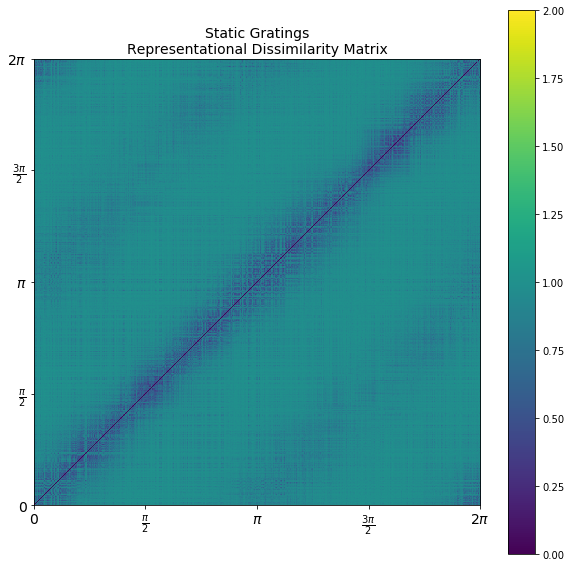

In [7]:
rdm_static, istim_static = make_rdm(dats['static'], title="Static Gratings\nRepresentational Dissimilarity Matrix")
print(istim_static)

[6.09159136e-04 7.18638172e-04 2.50309571e-03 ... 6.27388938e+00
 6.27438312e+00 6.28240486e+00]


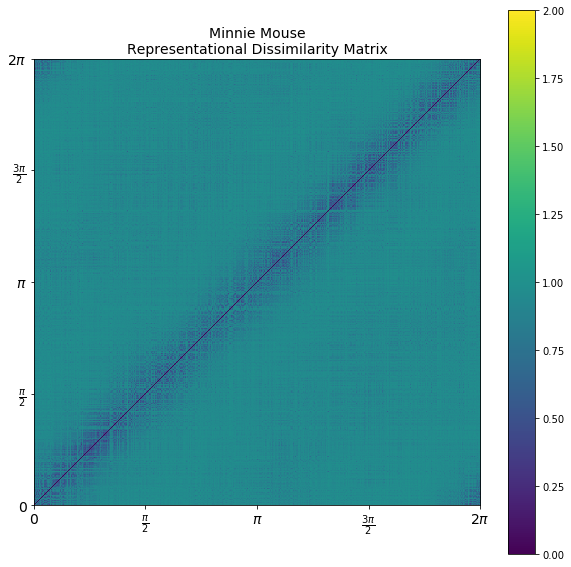

In [8]:
rdm_minnie, istim_minnie = make_rdm(dats['minnie'], title="Minnie Mouse\nRepresentational Dissimilarity Matrix")
print(istim_minnie)

In [9]:
corr_rdms(rdm_static, istim_static, rdm_minnie, istim_minnie)

(0.5443926662311008, 0.0)

In [44]:

# take lower triangles and find correlation coefficient
lt_static_sel = rdm_static_sel[np.tril_indices(len(rdm_static_sel), k=-1)]
lt_minnie_sel = rdm_minnie_sel[np.tril_indices(len(rdm_minnie_sel), k=-1)]

(0.5443926662311008, 0.0)


(0.5443926662311008, 0.0)

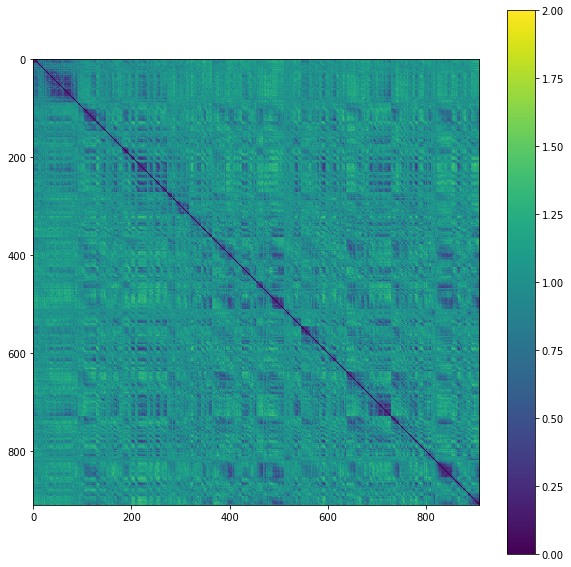

In [9]:
# create a data structure for spontaneous activity
static_spont = {}
static_spont['sresp'] = dats['static']['u_spont'] @ dats['static']['v_spont']
static_spont['istim'] = np.arange(len(static_spont['sresp'][1]))
rdm_spont_static, _ = make_rdm(static_spont)

### Split by high and low mutual information

In [129]:
MI_nthresh = 100
def select_MI_idx(MI, group="max", N=MI_nthresh, istart=None):
    idx = range(len(MI))
    idx_ordered = sorted(idx, key = lambda sub: MI[sub])
    if group == "max":
        if not istart is None:
            istart=len(idx)-istart
            iend = min(istart+N, len(idx))
            idx_sel = idx_ordered[istart:iend]
        else:
            idx_sel = idx_ordered[-N:] 
    elif group == "min":
        if not istart is None:
            iend = min(istart+N, len(idx))
            idx_sel = idx_ordered[istart:iend]
        else:
            idx_sel = idx_ordered[:N] 
    elif group == "all":
        idx_sel = idx_ordered
    return idx_sel

In [107]:
Z_static = zscore(dats['static']['sresp'], axis=1)
MI_static = mutual_information(Z_static, dats['static']['istim'])
Z_minnie = zscore(dats['minnie']['sresp'], axis=1)
MI_minnie = mutual_information(Z_minnie, dats['minnie']['istim'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


In [ ]:
MI_nthresh = 100
i = MI_nthresh
while i < len(dats['static']['sresp'])-MI_nthresh:
    dat_static_sub = deepcopy(dats['static'])
    dat_static_sub['sresp'] = dats['static']['sresp'][select_MI_idx(MI_static, group="max", N=MI_nthresh, istart=i),:]
    rdm_static_sub, istim_static = make_rdm(dat_static_sub, title="Static_Gratings_highest_%05d-%05d" % (i,i+MI_nthresh), save_plot=True)
    i += MI_nthresh


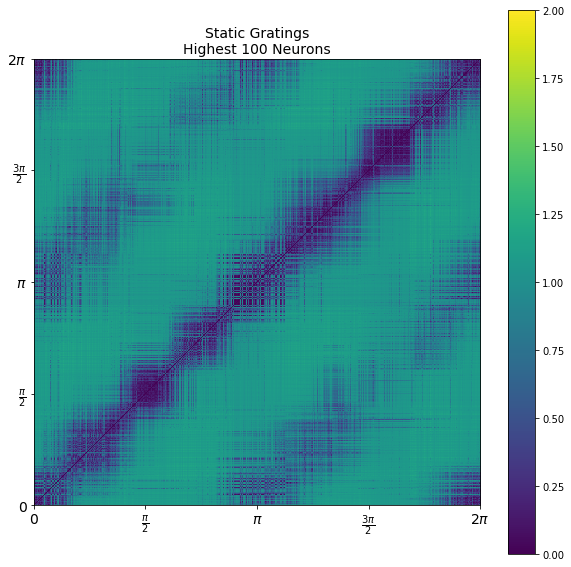

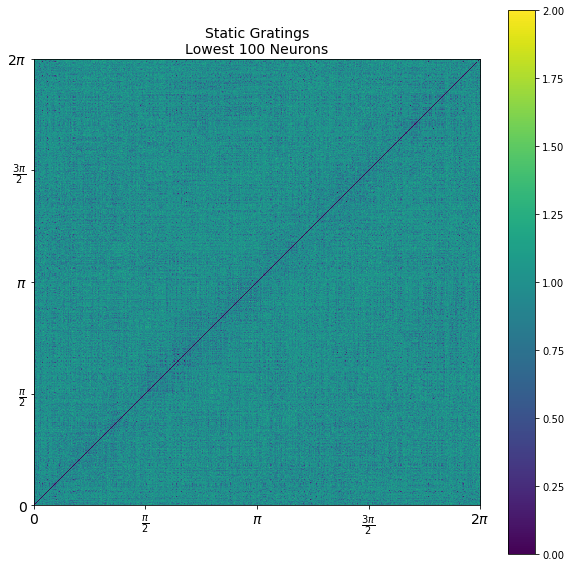

In [137]:
# Top and bottom 100 neurons - Static gratings
MI_nthresh = 100
dat_static_max = deepcopy(dats['static'])
dat_static_max['sresp'] = dats['static']['sresp'][select_MI_idx(MI_static, group="max", N=MI_nthresh),:]
rdm_static_max, istim_static = make_rdm(dat_static_max, title="Static Gratings\nHighest 100 Neurons")

dat_static_min = deepcopy(dats['static'])
dat_static_min['sresp'] = dats['static']['sresp'][select_MI_idx(MI_static, group="min", N=MI_nthresh),:]
rdm_static_min, istim_static = make_rdm(dat_static_min, title="Static Gratings\nLowest 100 Neurons")

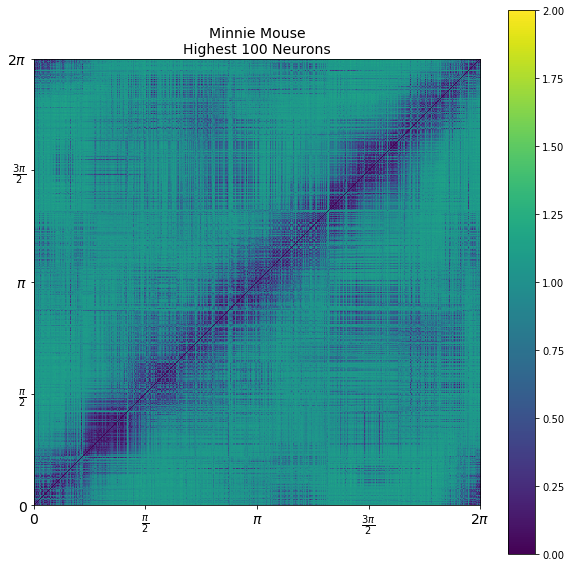

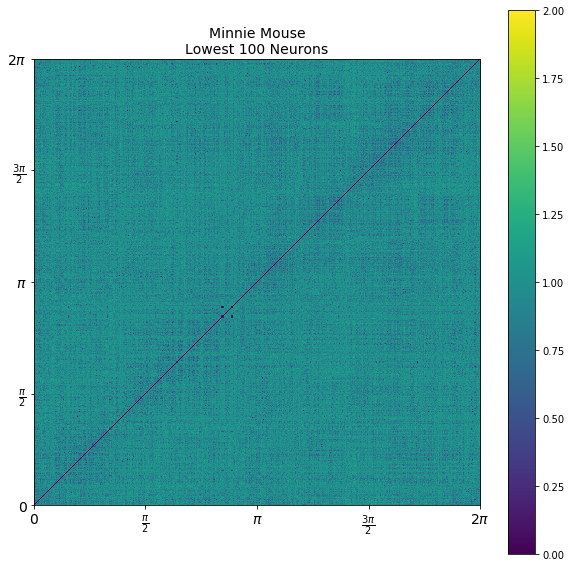

In [136]:
# Top and bottom 100 neurons - Minnie Mouse

MI_nthresh = 100

dat_minnie_max = deepcopy(dats['minnie'])
dat_minnie_max['sresp'] = dats['minnie']['sresp'][select_MI_idx(MI_minnie, group="max", N=MI_nthresh),:]
rdm_minnie_max, istim_minnie = make_rdm(dat_minnie_max, title="Minnie Mouse\nHighest 100 Neurons")

dat_minnie_min = deepcopy(dats['minnie'])
dat_minnie_min['sresp'] = dats['minnie']['sresp'][select_MI_idx(MI_minnie, group="min", N=MI_nthresh),:]
rdm_minnie_min, istim_minnie = make_rdm(dat_minnie_min, title="Minnie Mouse\nLowest 100 Neurons")

In [133]:
corr_rdms(rdm_static_max, istim_static, rdm_minnie_max, istim_minnie)

(0.5173712831163324, 0.0)

In [134]:
corr_rdms(rdm_static_min, istim_static, rdm_minnie_min, istim_minnie)

(0.01498526794576976, 0.0)

In [97]:
dat_static_100200 = deepcopy(dats['static'])
dat_static_100200['sresp'] = dats['static']['sresp'][select_MI_idx(MI_static, istart=100, iend=200),:]
rdm_static_100200, istim_static = make_rdm(dat_static_100200)

In [77]:
dat_minnie_1020 = deepcopy(dats['minnie'])
dat_minnie_1020['sresp'] = dats['minnie']['sresp'][select_MI_idx(MI_minnie, istart=10, iend=20),:]
rdm_minnie_1020, istim_minnie = make_rdm(dat_minnie_1020)

In [83]:
dat_static_1020 = deepcopy(dats['static'])
dat_static_1020['sresp'] = dats['static']['sresp'][select_MI_idx(MI_static, istart=10, iend=20),:]
rdm_static_1020, istim_static = make_rdm(dat_static_1020)

### Correlations between neurons' timeseries

In [ ]:
# Check for duplicate neurons
_, all_dup, uniq_dup = find_duplicates(dats['static'], thresh=1e-5)
print(all_dup)
print(uniq_dup)
# if there are duplicates off the diagonal, plot one of them
if len(uniq_dup) > 0:
    r = np.random.choice(np.arange(len(uniq_dup)), size=1)
    i = uniq_dup[r,0][0]
    j = uniq_dup[r,1][0]
    resp=dats['static']['sresp']
    print(i,j,rdm[i,j],np.corrcoef(resp[i,:], resp[j,:])[0,1])
    plt.scatter(resp[i,:], resp[j,:])

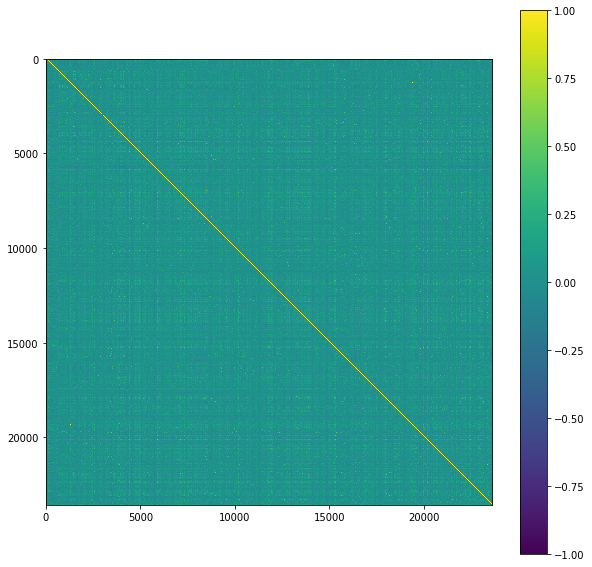

In [54]:
rdm_static_f= make_rdm_func_conn(dats['static'], size=23600)

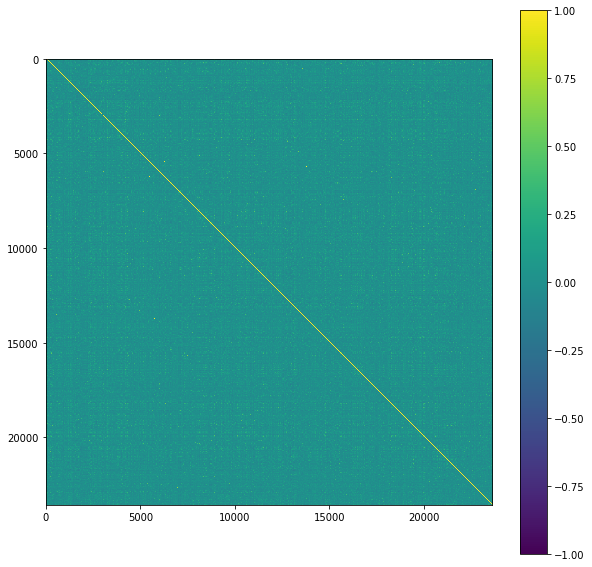

In [55]:
rdm_minnie_f= make_rdm_func_conn(dats['minnie'], size=23600)

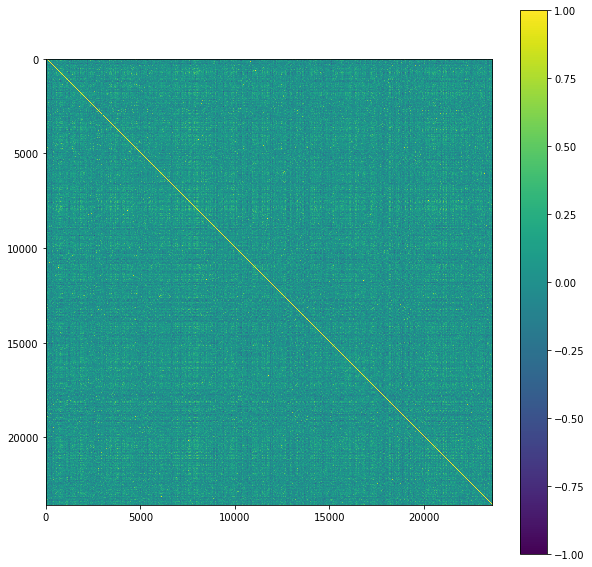

In [67]:
rdm_spont_f= make_rdm_func_conn(static_spont, size=23600)

## Try decoding minnie mouse RDM from static RDM

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

rdm_static_sel_std = StandardScaler().fit_transform(rdm_static_sel)
rdm_minnie_sel_std = StandardScaler().fit_transform(rdm_minnie_sel)

lm = LinearRegression()
lm.fit(rdm_static_sel_std, stim_intersect)

mlp = MLPRegressor(solver='lbfgs',activation= 'tanh' , alpha=1e-5, hidden_layer_sizes=(20,1), random_state=1, max_iter = 1e4)
mlp.fit(rdm_static_sel_std, stim_intersect)

MLPRegressor(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(20, 1), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000.0,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

Linear Regression R^2:
-317.8729841717563


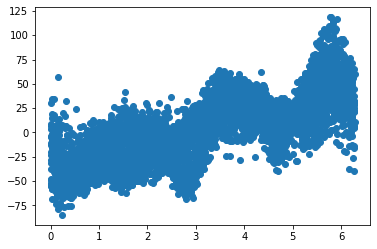

In [ ]:
# for some reason the scale here is very off, so needs debugging

print("Linear Regression R^2:")
print(lm.score(rdm_minnie_sel_std, stim_intersect))
plt.scatter(y=lm.predict(rdm_minnie_sel_std), x=stim_intersect)

0.19272265135623978


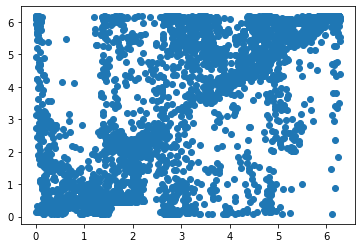

In [ ]:
print(mlp.score(rdm_minnie_sel_std, stim_intersect))
plt.scatter(y=mlp.predict(rdm_minnie_sel_std), x=stim_intersect)

## Plot MDS dimensions of RDMs

In [ ]:
seed=123
mds = manifold.MDS(n_components=2, max_iter=10000, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)


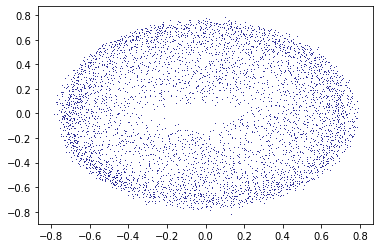

In [ ]:
# Plot MDS of static data
pos_static = mds.fit(rdm_static_sel).embedding_
plt.scatter(pos_static[:, 0], pos_static[:, 1], color='navy', s=1, lw=0, label='Static')

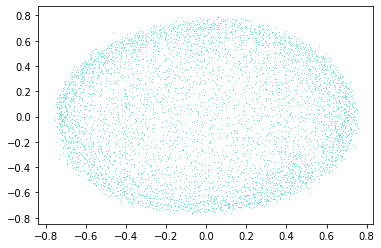

In [ ]:
# Plot MDS of minnie mouse data
pos_minnie = mds.fit(rdm_minnie_sel).embedding_
plt.scatter(pos_minnie[:, 0], pos_minnie[:, 1], color='turquoise', s=1, lw=0, label='Minnie')

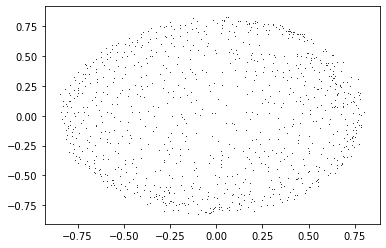

In [ ]:
# Plot MDS of spontaneous data
pos_spont = mds.fit(rdm_spont_static).embedding_
plt.scatter(pos_spont[:, 0], pos_spont[:, 1], color='black', s=1, lw=0, label='spont')

### 3-D MDS

In [68]:
seed=123
mds3 = manifold.MDS(n_components=3, max_iter=10000, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)

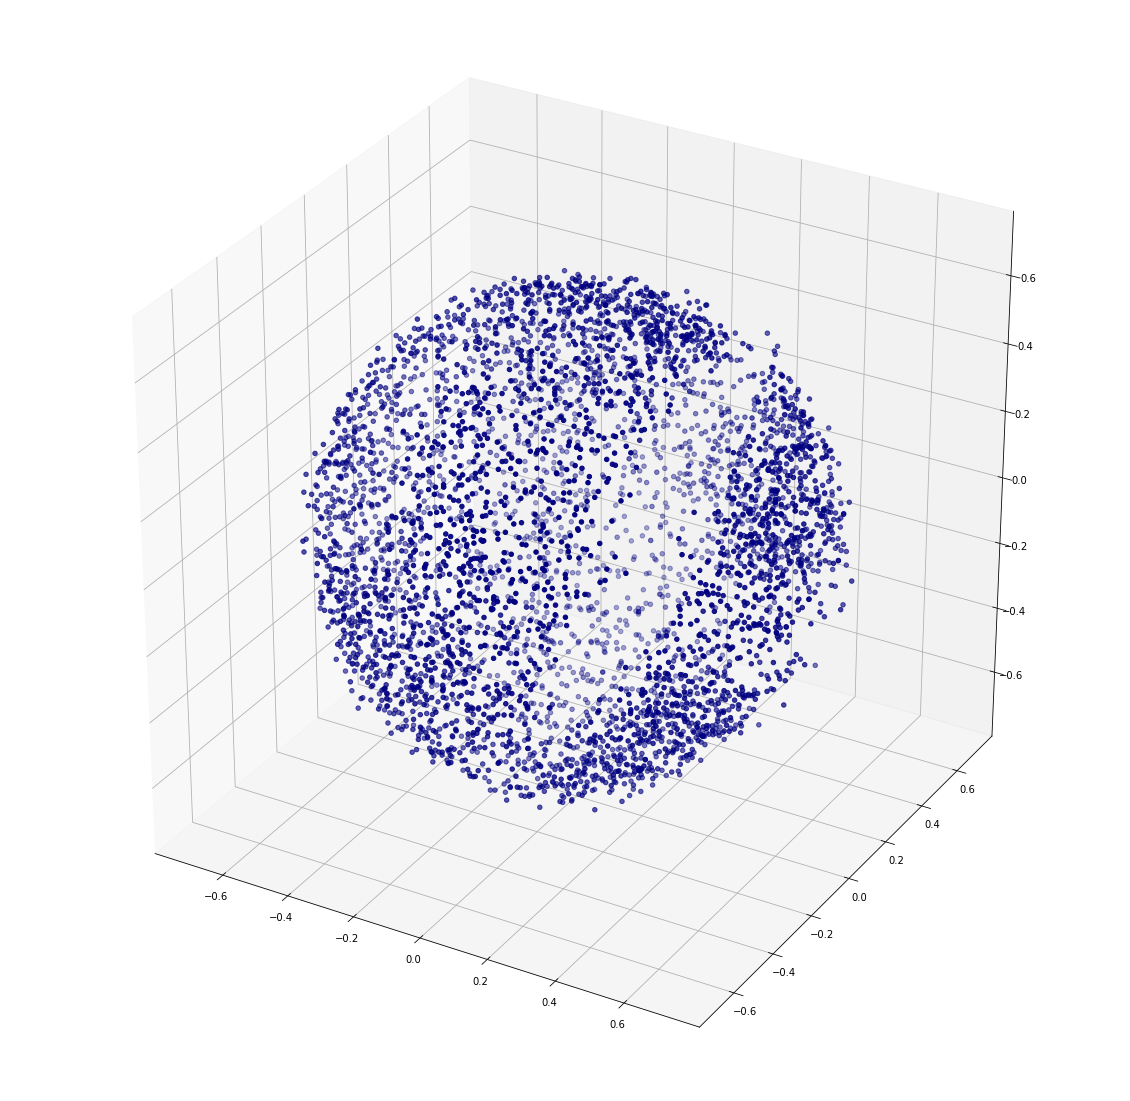

In [76]:
# Plot MDS of static data
pos_static3 = mds3.fit(rdm_static_sel).embedding_
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_static3[:, 0], pos_static3[:, 1], pos_static3[:, 2], color='navy', label='Static')

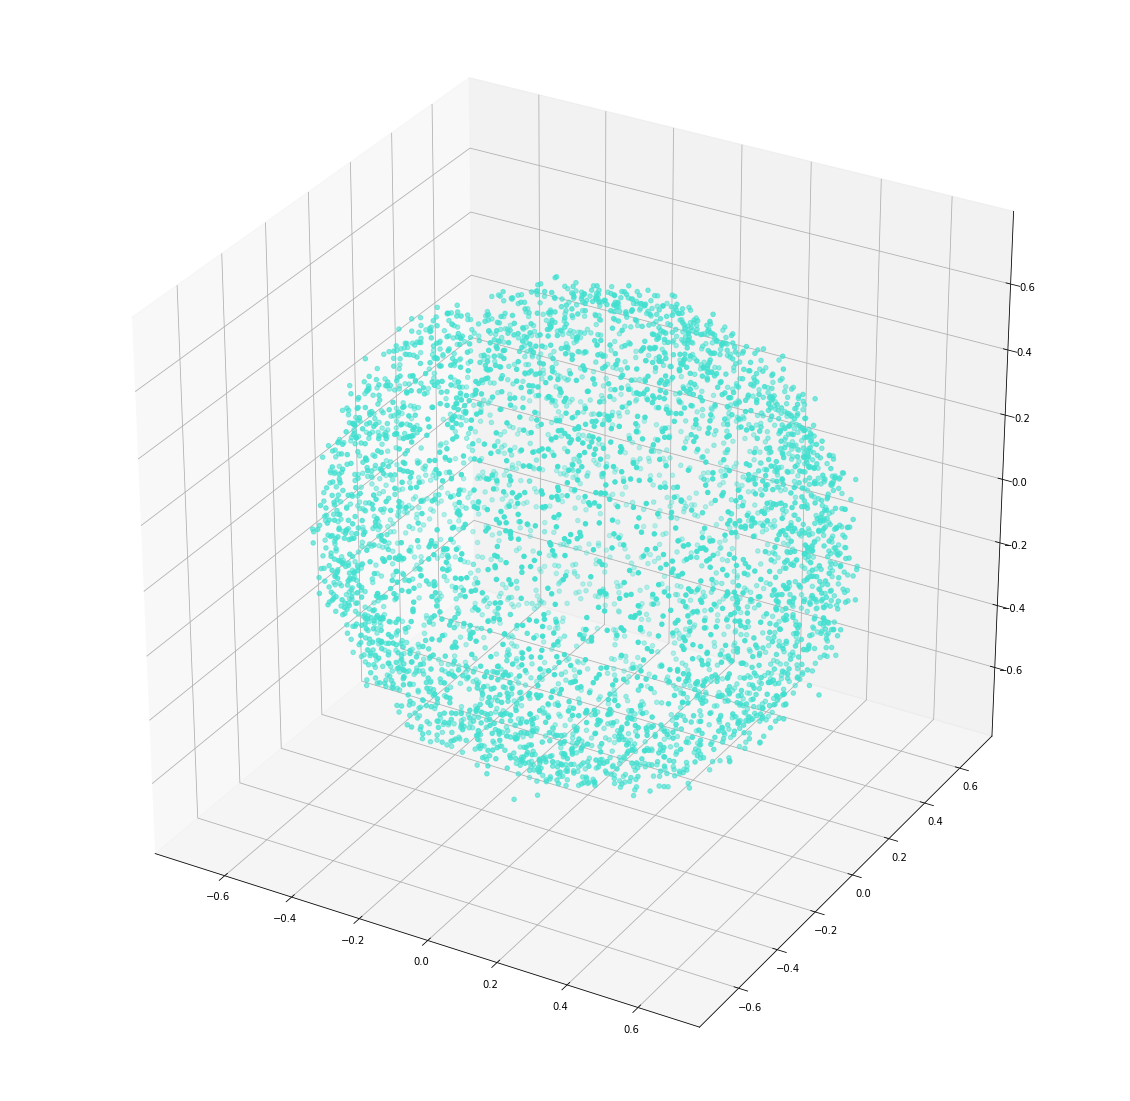

In [77]:
# Plot MDS of minnie mouse data
pos_minnie3 = mds3.fit(rdm_minnie_sel).embedding_
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_minnie3[:, 0], pos_minnie3[:, 1], pos_minnie3[:, 2], color='turquoise', label='Static')

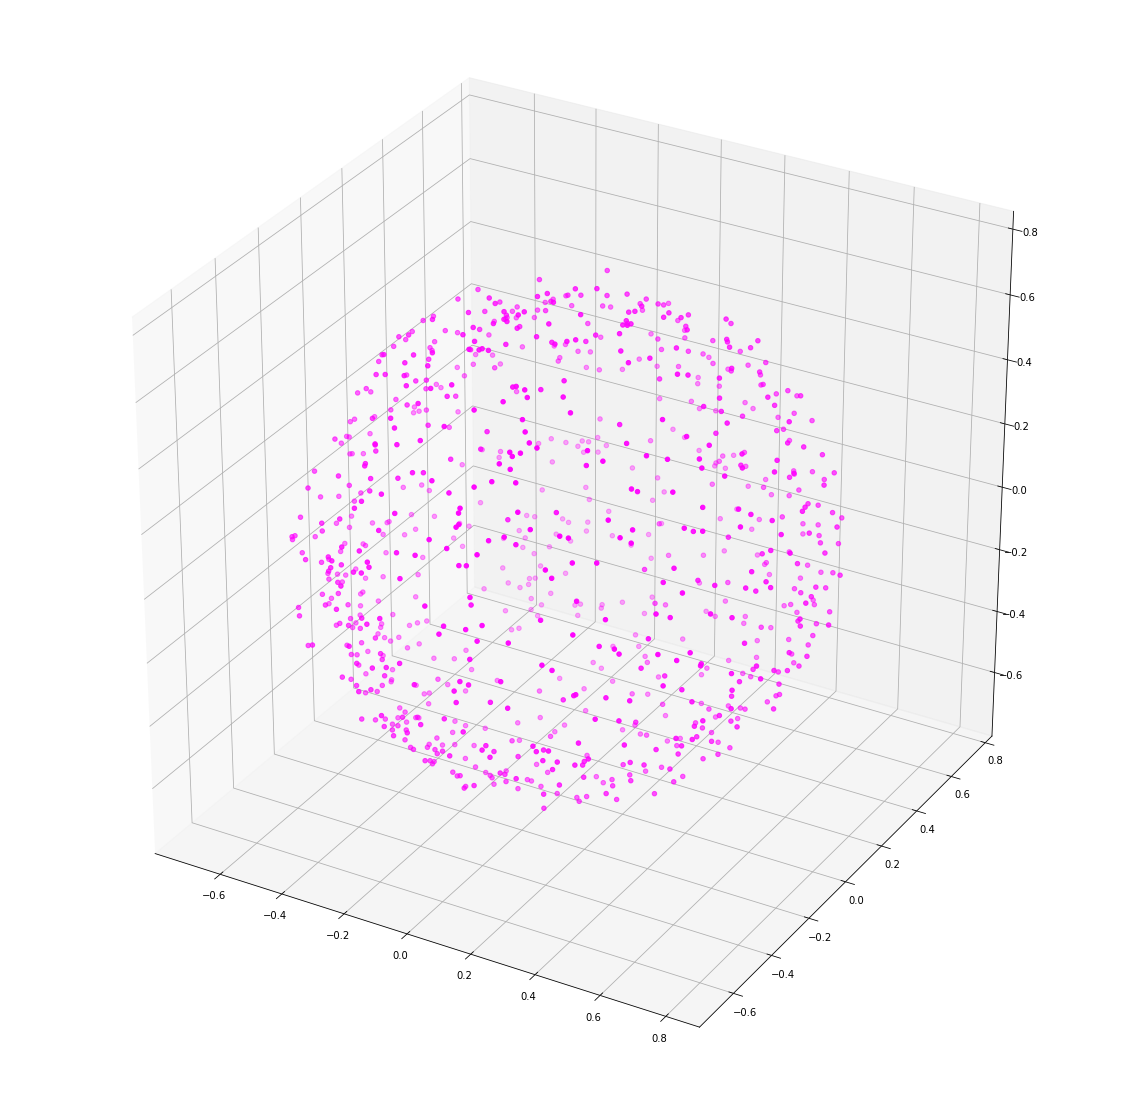

In [79]:
# Plot MDS of spontaneous data
pos_spont3 = mds3.fit(rdm_spont_static).embedding_
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_spont3[:, 0], pos_spont3[:, 1], pos_spont3[:, 2], color='magenta', label='Static')

## UMAP (TODO)

In [ ]:
# !pip install umap-learn
# from umap import UMAP
# ncomp = 2 
# xinit = 3 * zscore(X[:,:ncomp], axis=0)
# embedding = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 25, 
#              metric = 'correlation', transform_seed = 42).fit_transform(X)

In [ ]:
# plt.figure(figsize=(8,8))
# for i in range(ncomp):
#   for j in range(ncomp):
#     plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
#     if i==j:
#       plt.scatter(dat['istim'], embed[:,i], s  = 1)
#     else:
#       plt.scatter(embed[:,j], embed[:,i], s  = 1, c= dat['istim'], cmap = 'hsv')